<a href="https://colab.research.google.com/github/IgorJoaquimn/2023-Small-World-Networks/blob/main/Small_World_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Small World Networks Analysis**
Alunos:

Giovana Assis da Matta Machado (2021031947)

Igor Joaquim da Silva Costa (2021032218)

Muitos problemas interessantes surgem ao estudar as propriedades de redes geradas aleatoriamente. Uma rede é uma coleção de nós e arestas, onde cada aresta conecta dois nós, mas cada nó pode estar conectado a qualquer número de arestas. Uma rede aleatória é construída probabilisticamente de acordo com regras definidas. O estudo de redes aleatórias é geralmente feito examinando o conjunto completo de redes, cada uma ponderada pela probabilidade de ter sido construída, o que se encaixa naturalmente no escopo da mecânica estatística.

In [ ]:
import numpy as np # so por garantia precaução
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor,ceil
from numba import njit

In [ ]:
class small_world_graph():
  def __init__(self,L,Z):
    self.L = L
    self.Z = Z
    self.nodes = np.arange(self.L)
    self.edges = [(i,z%self.L) for i in range(self.L) for z in range((i-self.Z//2),(i+self.Z//2)) if i != z%self.L]
    self.short_edges = self.get_short_edges()
    return None

  def get_short_edges(self): # Create the graph containing all the edges on distance Z//2 from every node
    G = nx.Graph()

    G.add_nodes_from(self.nodes)
    G.add_edges_from(self.edges)
    self.short_edges = G
    return self.short_edges

  def get_long_edges(self,p): # Create p random long edges and aggregate them to the short_graph
    G = nx.Graph()

    G.add_nodes_from(self.nodes)
    G.add_edges_from(self.edges)

    size = floor(p*self.L*(self.Z/2))
    X = np.random.randint(0,self.L,size)
    Y = np.random.randint(0,self.L,size)

    G.add_edges_from(zip(X,Y))

    self.num_long_edges = size
    self.long_edges = G
    return G

  def get_all_paths_length(self): # Create the distance matrix of graph
    N = self.L
    distance_matrix = np.identity(N)
    paths = dict(nx.all_pairs_shortest_path(self.long_edges))

    for source in range(N):
        for target in range(N):
            distance_matrix[source][target] = len(paths[source][target]) -1
    self.distance_matrix = distance_matrix
    self.paths = paths
    return distance_matrix

  def get_mean_paths(self,p):
    return nx.average_shortest_path_length(self.get_long_edges(p))

##**1.0 Distribuição dos caminhos**

###**1.1 Visualizando os caminhos**
Quando adicionamos atalhos, esperamos que essa distribuição seja deslocada para caminhos mais curtos, refletindo a natureza interconectada e a capacidade de atingir rapidamente outros nós na rede.

Gráficos para N = 1.000 e Z = 2 para p = 0,02

In [ ]:
L=1000
Z=2
G = small_world_graph(L,Z)
long_edges = G.get_long_edges(0.02)

In [ ]:
colors = plt.cm.hsv(np.linspace(0, 1, L))
degrees = dict(long_edges.degree)

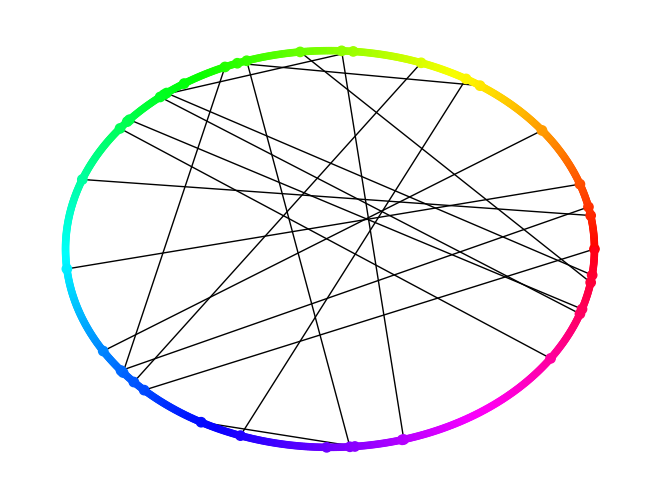

In [ ]:
nx.draw_circular(long_edges,node_color=colors,node_size=[((v/2)**2)*20 for v in degrees.values()])

In [ ]:
paths_1 = G.get_all_paths_length().reshape(-1)

Gere gráficos para N = 1.000 e Z = 2 para p = 0,2

In [ ]:
G = small_world_graph(L,Z)
long_edges = G.get_long_edges(0.2)

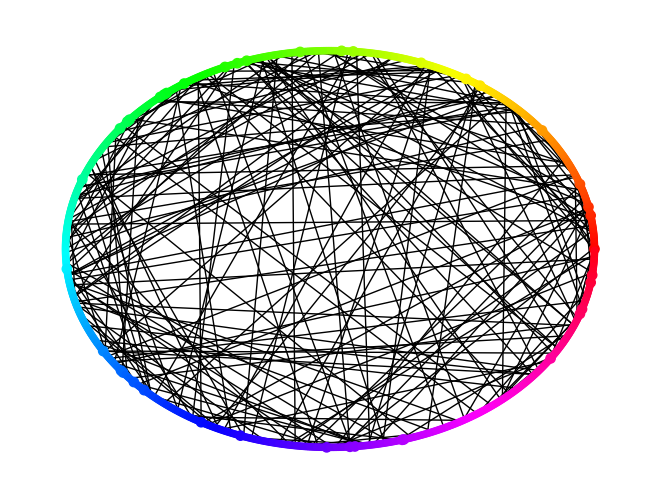

In [ ]:
nx.draw_circular(long_edges,node_color=colors,node_size=[((v/2)**2)*20 for v in degrees.values()])

In [ ]:
paths_2 = G.get_all_paths_length().reshape(-1)

Distribuição dos caminhos para p=0,02 e p=0,2



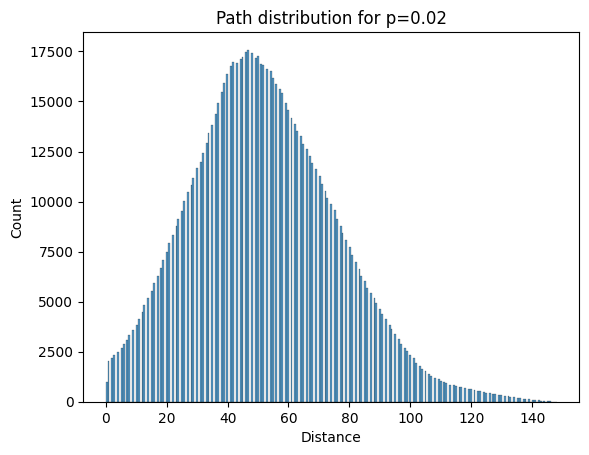

Text(0, 0.5, 'Count')

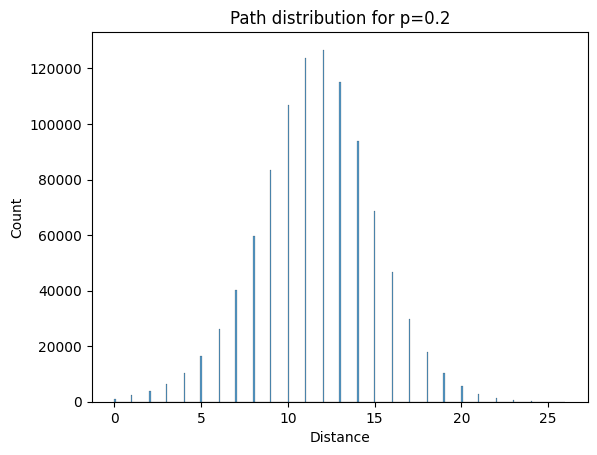

In [ ]:
sns.histplot(paths_1)

plt.title(f'Path distribution for p=0.02')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.show()
sns.histplot(paths_2)
plt.title(f'Path distribution for p=0.2')
plt.xlabel('Distance')
plt.ylabel('Count')

Para entender melhor as características dos grafos Small World, vamos variar o valor de P para um grafo com L = 1000 e Z = 2, visualizando os histogramas para cada um:

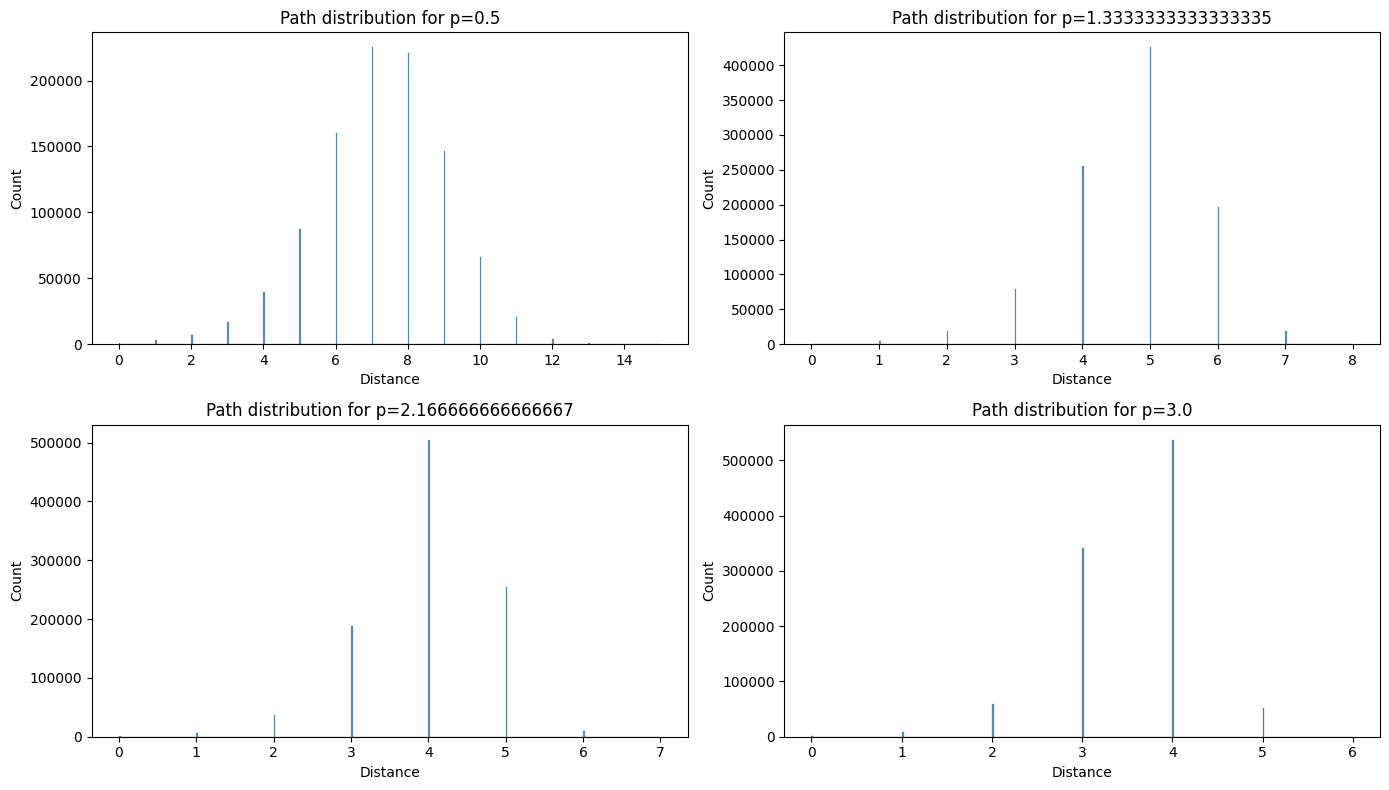

In [ ]:
p_vector = np.linspace(0.5,3.0,4)
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Redefina o índice do subplot
subplot_index = 0

G = small_world_graph(L,Z)
for p in p_vector:
  G.get_long_edges(p)
  row, col = subplot_index // 2, subplot_index % 2
  sns.histplot( G.get_all_paths_length().reshape(-1),ax = axs[row, col])
  axs[row, col].set_title(f'Path distribution for p={p}')
  axs[row, col].set_xlabel('Distance')
  axs[row, col].set_ylabel('Count')
  axs[row, col].grid(False)

  subplot_index += 1
plt.tight_layout()
plt.show()

Como podemos ver, a medida que aumentamos p, o **o caminho médio diminui**, além da distribuição apresentar **menor variabilidade**. Isso se dá pela maior existência de arestas longas na estrutura do grafo

#### Que valor de p você precisaria para obter “seis graus de separação”?


Text(0, 0.5, 'Count')

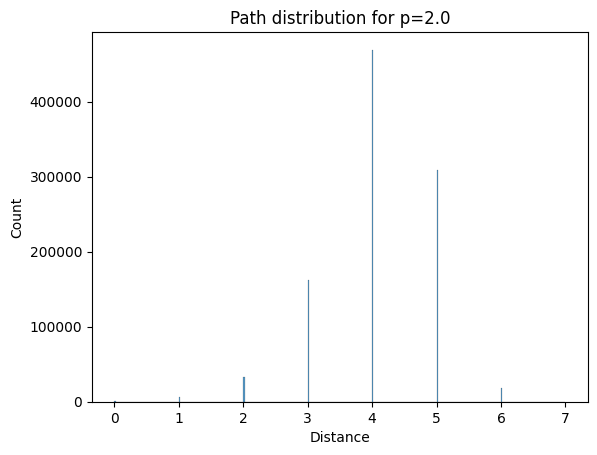

In [ ]:
G = small_world_graph(L,Z)
long_edges = G.get_long_edges(2.0)
sns.histplot(G.get_all_paths_length().reshape(-1))
plt.title(f'Path distribution for p=2.0')
plt.xlabel('Distance')
plt.ylabel('Count')

###**1.2 Média dos caminhos**

Para realizar os experimentos, criamos uma instância da classe small_world_graph com esses parâmetros. Em seguida, executamos o cálculo da média dos caminhos mais curtos na rede para avaliar como a introdução de atalhos afeta essa média. Repetimos esse processo 1000 vezes para obter uma amostra representativa.

Os resultados dessas 1000 execuções são armazenados em uma lista chamada short_path_distance. Para entender melhor como as médias dos caminhos mais curtos estão distribuídas na rede, geramos um histograma.

In [ ]:
L = 100
Z = 2
p = 0.1
G = small_world_graph(L,Z)

In [ ]:
short_path_distance = [G.get_mean_paths(p) for i in range(1000)]

<Axes: ylabel='Count'>

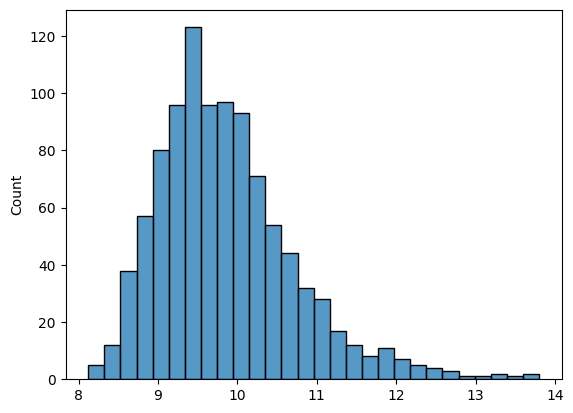

In [ ]:
sns.histplot(short_path_distance)

Quantidade de arestas longas:

In [ ]:
G.num_long_edges

10

A flutuação nas distâncias é esperada e pode ser atribuída à aleatoriedade na adição de arestas. Existem dois cenários possíveis:

* Arestas longas ligam nós distantes, diminuindo a distância esperada
* Arestas longas sobrepoem arestas já existentes, mantendo a mesma distribuição

O primeiro caso é sutil, já que a não repetição de arestas pode afetar arbitrariamente a média, enquanto a repetição pode, no pior caso, fazer com que o grafo gerado seja equivalente ao grafo com p=0.0.

Isso explica as flutuações, principalmente na calda pesada, já que esses casos raros são justamente quando ocorre adição de arestas repetidas.

##**2.0 Curva de Watts e Strogatz**

Plotamos o comprimento médio do caminho entre os nós d(p) dividido por d(p = 0)
para Z = 2, N = 50, em função de p em um gráfico semi-log com valores entre p =
0,001 e p = 1000.

In [ ]:
L=50
Z=2
G = small_world_graph(L,Z)

In [ ]:
p_inicial = 0.001
p_final = 1000
fator_deslocamento = 10

p_ticks = np.logspace(np.log10(p_inicial), np.log10(p_final), fator_deslocamento)

In [ ]:
path_zero = G.get_mean_paths(0)

In [ ]:
short_path_distance = [G.get_mean_paths(p)/path_zero for p in p_ticks]

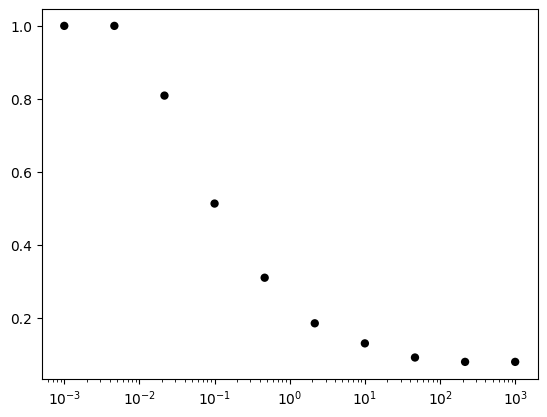

In [ ]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(p_ticks,short_path_distance, edgecolors='none',c="black")
ax.set_xscale('log')

O gráfico é fixado em 1 para p pequeno porque, para p muito pequeno, a rede é essencialmente uma rede regular, e o comprimento médio do caminho é o mesmo que na rede regular (d(p) = d(p=0)). À medida que p aumenta, a rede começa a se assemelhar a uma rede aleatória e o comprimento médio do caminho aumenta. O gráfico acima reflete essa transição de uma rede regular para uma rede aleatória.

##**3.0 Caminho de Watts e Strogatz**
 Criamos um gráfico circular de sua geometria da parte (c) (Z = 2, N = 50)

In [ ]:
L=50
Z=2
p = 0.1

G = small_world_graph(L,Z)
long_edges = G.get_long_edges(p)
colors = plt.cm.hsv(np.linspace(0, 1, L))
degrees = dict(long_edges.degree)

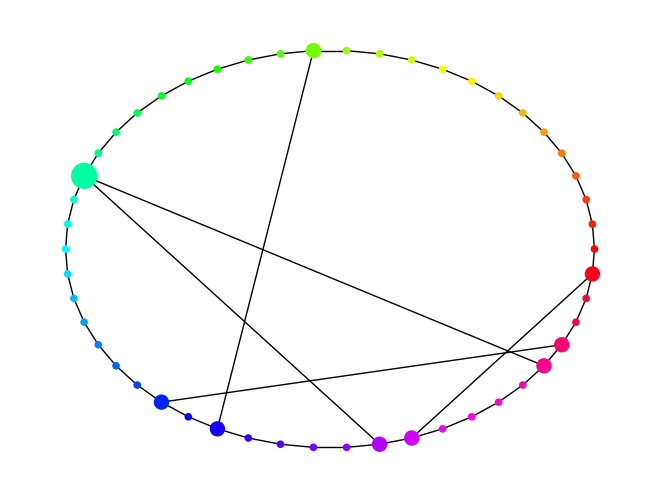

In [ ]:
nx.draw_circular(long_edges,node_color=colors,node_size=[((v/2)**4)*20 for v in degrees.values()])

crie e exiba gráficos circulares da geometria de Watts e Strogatz Z = 10, N =
1.000 em p = 0,1 e p = 0,001

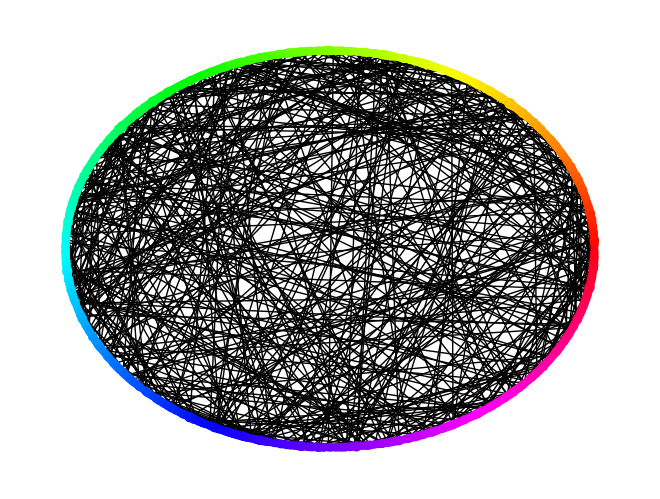

In [ ]:
L = 1000
Z = 10
p = 0.1

long_edges = nx.watts_strogatz_graph(L,Z,p)
colors = plt.cm.hsv(np.linspace(0, 1, L))
degrees = dict(long_edges.degree)
nx.draw_circular(long_edges,node_color=colors,node_size=[((v/2)**2) for v in degrees.values()])

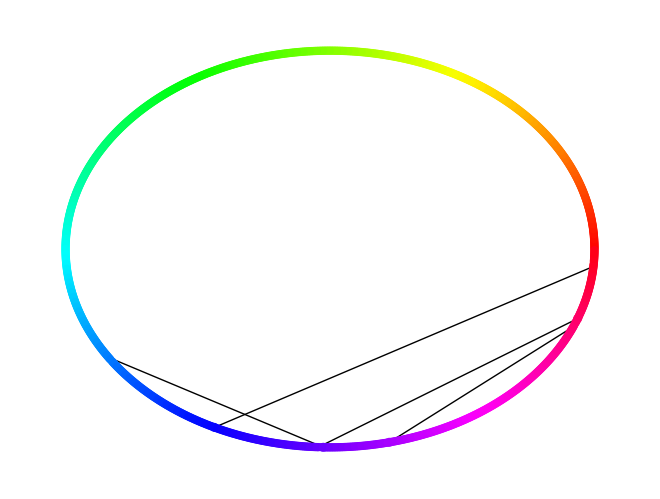

In [ ]:
p = 0.001

long_edges = nx.watts_strogatz_graph(L,Z,p)
colors = plt.cm.hsv(np.linspace(0, 1, L))
degrees = dict(long_edges.degree)
nx.draw_circular(long_edges,node_color=colors,node_size=[((v/2)**2) for v in degrees.values()])

O sistema de Watts e Strogatz para p = 0.001 se assemelha mais a geometria da parte

Plote o comprimento médio do caminho redimensionado, pi*Z*d/L , versus o número
total de atalhos, p*L*(Z/2), para um intervalo de 0,001 < p < 1000, para L = 100 e 200
e para Z = 2 e 4 .

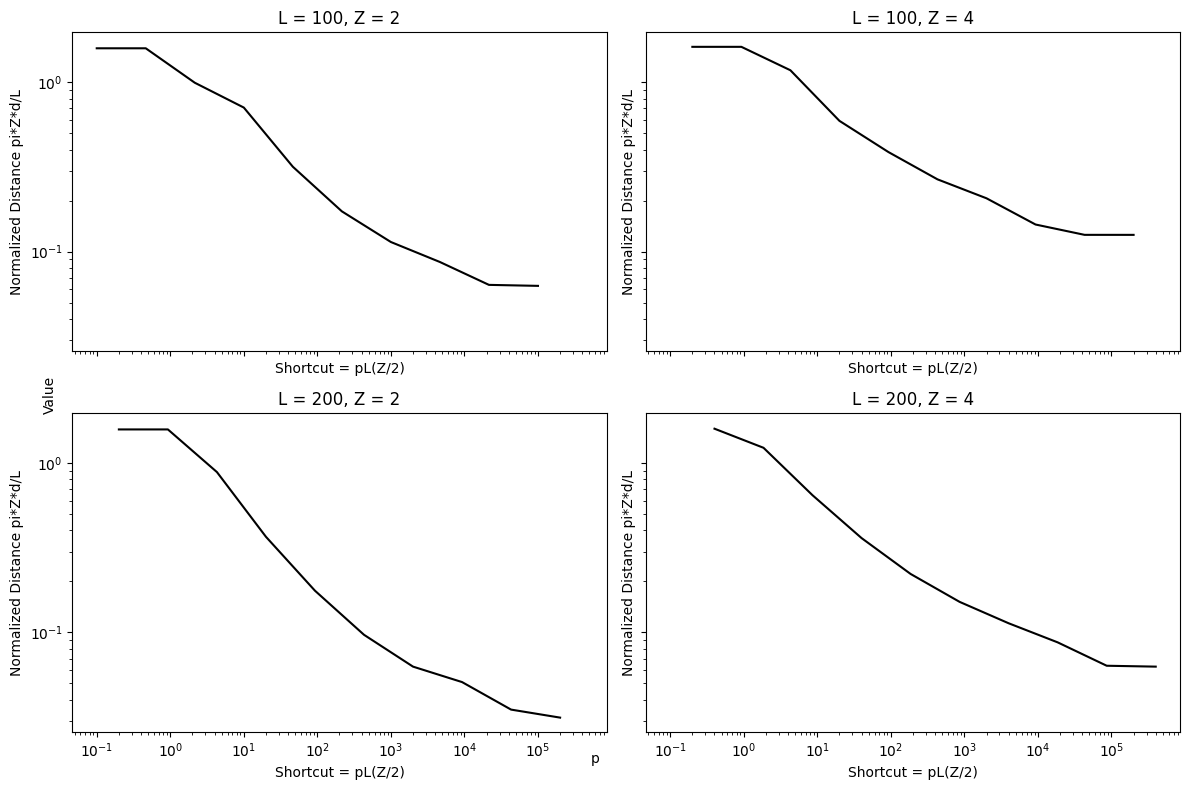

In [ ]:
L_values = [100, 200]
Z_values = [2, 4]

pi = np.pi

fig, axs = plt.subplots(len(L_values), len(Z_values), figsize=(12, 8), sharex=True, sharey=True)
for i, L in enumerate(L_values):
    for j, Z in enumerate(Z_values):
        G = small_world_graph(L,Z)
        short_path_distance = [pi*Z*G.get_mean_paths(p)/L for p in p_ticks]
        shortcuts = [p*L*(Z/2) for p in p_ticks]

        ax = axs[i, j]
        ax.plot(shortcuts, short_path_distance, c="black")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(f'L = {L}, Z = {Z}')
        ax.set_ylabel("Normalized Distance pi*Z*d/L")
        ax.set_xlabel("Shortcut = pL(Z/2)")

fig.text(0.5, 0.04, 'p', ha='center')
fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

plt.tight_layout()
plt.show()


Como podemos ver, a relação se torna quase linear em alguns pontos

## Redes Reais

download zip

In [ ]:
import requests
import zipfile
import io

network_name = 'fb-pages-food'
url = f"https://nrvis.com/download/data/soc/{network_name}.zip"
local_file_path = '/content/graph.zip'

response = requests.get(url)
with open(local_file_path, 'wb') as file:
  file.write(response.content)

with zipfile.ZipFile(local_file_path, 'r') as zip_ref:
    zip_ref.extractall('')  # Replace 'extracted_directory' with the desired directory for extraction.

In [ ]:
df_edges = pd.read_csv(network_name+".edges",header=None)
df_edges.head()

,0,1
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


In [ ]:
df_nodes = pd.read_csv(network_name+".nodes")
df_nodes.head()

,id,name,new_id
0,402449106435352,Josh Marks,386
1,368969274888,Blue Ribbon Restaurants,473
2,765596333518863,Pat Neely,1
3,136870209668885,La Griglia,542
4,840078802741859,Jose Garces,189


In [ ]:
G = nx.Graph()
G.add_edges_from(df_edges.values)

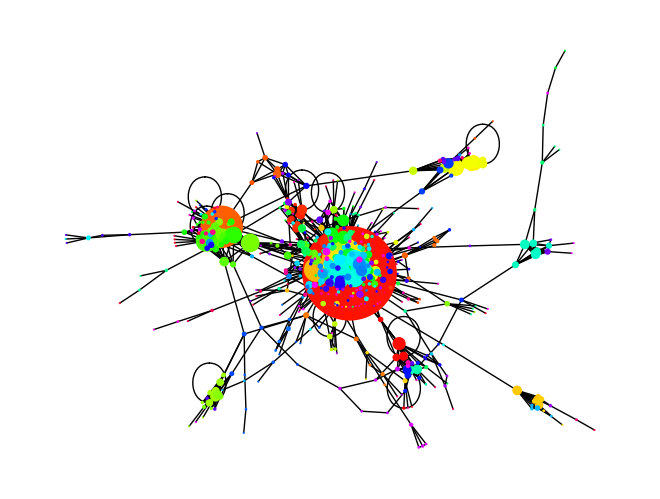

In [ ]:
L = len(G.nodes)
colors = plt.cm.hsv(np.linspace(0, 1, L))
degrees = dict(G.degree)

nx.draw(G,node_color=colors,node_size=[((v/2)**2) for v in degrees.values()])

In [ ]:
nx.average_shortest_path_length(G)

5.088696649121893

In [ ]:
N = L
distance_matrix = np.identity(N)
paths = dict(nx.all_pairs_shortest_path(G))

for source in range(N):
  for target in range(N):
    distance_matrix[source][target] = len(paths[source][target]) -1

(array([4.80200e+03, 9.08660e+04, 1.40146e+05, 5.67740e+04, 6.90000e+04,
        1.73680e+04, 2.86000e+03, 1.94600e+03, 5.60000e+02, 7.80000e+01]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

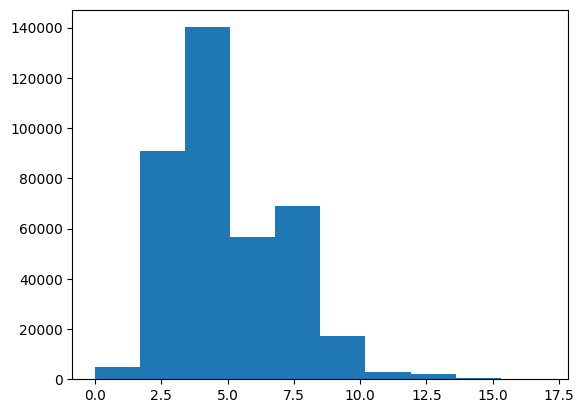

In [ ]:
plt.hist(distance_matrix.reshape(-1))

In [ ]:
%%shell
jupyter nbconvert --to html /content/Small_World_Networks.ipynb

[NbConvertApp] Converting notebook /content/Small_World_Networks.ipynb to html
[NbConvertApp] Writing 2065387 bytes to /content/Small_World_Networks.html
